In [139]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

In [140]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model running via: {device}")

# Synthetic Data points
total_points_dataset = 50
complexity_range = 1

# Model Parameters
num_epochs = 4000
input_dim = 1
output_dim = 1
hidden_dims = ([300, 300, 300, 300, 300, 300, 300])
embedding_dim = 0


# Synthetic data function
def F(y):
    return np.sin(8 * np.pi * y + np.pi / 10)
    return (6 * y - 2)**2 * np.sin(12 * y - 4) - 10 * (y - 1)**2


# Random ranged data array
Z = torch.linspace(0, complexity_range, 1000)[:,None]

# Model's total training/val/testing dataset
X = torch.linspace(0, complexity_range, total_points_dataset, dtype=torch.float32)[:,None]

# Splitting dataset
Placeholder, X_test, Place_holder, Y_test = train_test_split(X, F(X), test_size=0.8)

X_train = torch.linspace(0, complexity_range, total_points_dataset)[:,None] # .long()
Y_train = F(X_train) # .float()

# Transfering data to GPU for CUDA
X_train = X_train.to(device); X_test = X_test.to(device)
Y_train = Y_train.to(device); Y_test = Y_test.to(device)

Model running via: cuda


In [141]:
class Network(torch.nn.Module):
  def __init__(self, hidden_dims, input_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc4 = nn.Linear(hidden_dims[3], hidden_dims[4])
    # self.dropout = nn.Dropout(0.1)
    self.fcEND = nn.Linear(hidden_dims[4], output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    # x = self.dropout(x)
    x = self.fcEND(x)
    return x

model = Network(hidden_dims, input_dim, output_dim).to(device)

for param in model.parameters():
    param.requires_grad = True

In [142]:
# Training
losses = [] 
val_losses = []
prev_loss = []
loss = torch.zeros(1)

batch_size = 20

# Loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # weight_decay=1e-5

for epoch in range(num_epochs):
    shuffled_indices = torch.randperm(X_train.size(0))
    X_train = X_train[shuffled_indices]
    Y_train = Y_train[shuffled_indices]
    
    # Batches
    num_batches = X_train.size(0) // batch_size
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size
        X_batch = X_train[start:end]
        Y_batch = Y_train[start:end]

    # Training
    prev_loss = loss.item()
    y_pred = model(X_train.to(device))
    Y_train = Y_train.reshape(*X_train.shape)
    loss = criterion(y_pred, Y_train.to(device))
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Validation
    shuffled_indices_val = torch.randperm(X_test.size(0))
    X_test = X_test[shuffled_indices_val]
    Y_test = Y_test[shuffled_indices_val]

    num_batches_val = X_test.size(0) // batch_size
    for batch in range(num_batches_val):
        start = batch * batch_size
        end = start + batch_size
        X_batch = X_test[start:end]
        Y_batch = Y_test[start:end]

    val_outputs = model(X_test)
    val_loss = criterion(val_outputs, Y_test)
    val_losses.append(val_loss.item())

    current_loss = loss.item()
    if abs(current_loss - prev_loss) < 1e-9:
        break

Error: 5.252748518752725
 Number of Epochs needed (out of 4000): 3025
 Training Loss of Model: 0.0004979934310540557


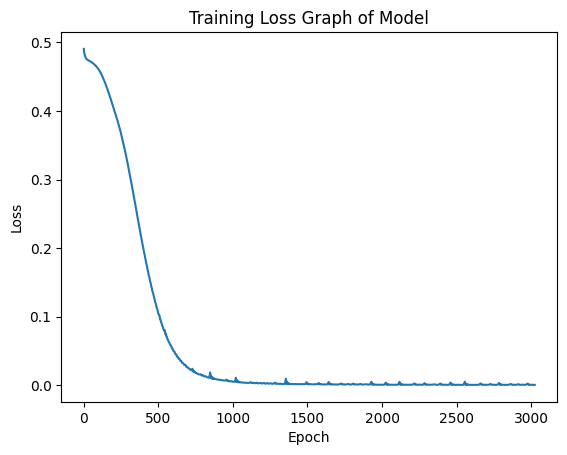

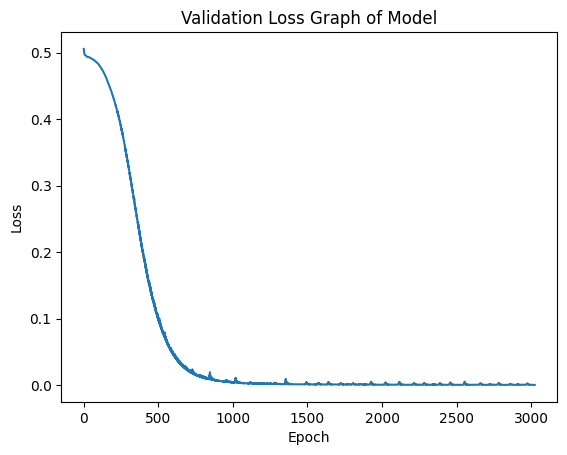

In [143]:
# Calculating Error of model via valiation set
percentage_errors = []

for i in range(len(losses)):
    abs_error = ((abs(losses[i] - val_losses[i]))/2)
    percentage_error = (abs_error / val_losses[i]) * 100
    percentage_errors.append(percentage_error)
    
average_percentage_error = sum(percentage_errors) / len(percentage_errors)
print(f"Error: {average_percentage_error}")

print(f" Number of Epochs needed (out of {num_epochs}): {len(losses)}")
print(f" Training Loss of Model: {loss}")
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Graph of Model')
plt.show()

plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Graph of Model')
plt.show()

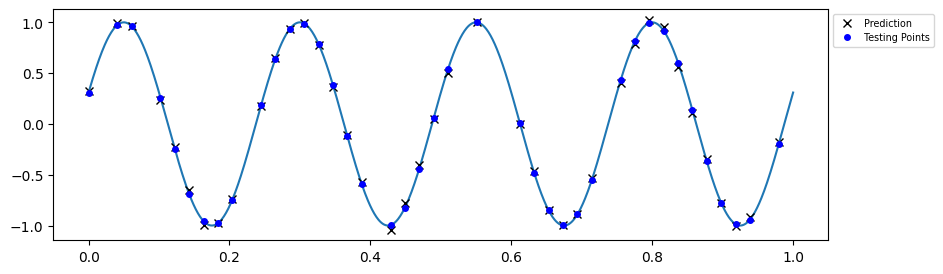

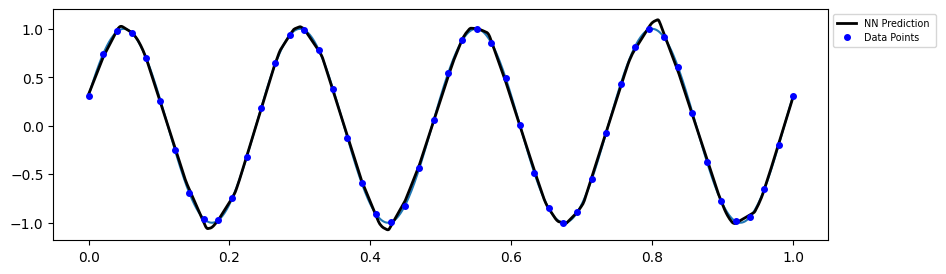

In [144]:
model.eval()

for layer in model.modules():
    if isinstance(layer, torch.nn.BatchNorm2d):
        layer.eval()

with torch.no_grad():
    Y_test_prediction = model(X_test.to(device)) # Testing Data
    y_pred_new = model(Z.to(device)) # Define the NEW input data


# Testing Data
plt.figure(figsize=(10,3))
plt.plot(Z, F(Z)) 
plt.plot(X_test.cpu().detach().numpy(), Y_test_prediction.cpu().detach().numpy(), "kx", label='Prediction')
plt.plot(X_test.cpu().detach().numpy(), Y_test.cpu().detach().numpy(),"bo", markersize = 4, label='Testing Points')
# plt.plot(X_test.cpu().detach().numpy(), Y_test_prediction.cpu().detach().numpy(),'x', lw=2, label= "NN Prediction ")
# plt.plot(X_test.cpu().detach().numpy(), Y_test.cpu().detach().numpy(), 'bo', markersize = 4, label = 'Data Points')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
plt.show()


# Define the NEW input datax
plt.figure(figsize=(10,3))
plt.plot(Z, F(Z)) 
plt.plot(Z.cpu().detach().numpy(), y_pred_new.cpu().detach().numpy(),'k', lw=2, label= "NN Prediction ")
plt.plot(X_train.cpu().detach().numpy(), Y_train.cpu().detach().numpy(), 'bo', markersize = 4, label = 'Data Points')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
plt.show()